In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

## Generate data

$f(x)=\sin(2\pi x)+0.5\sqrt{1-x^2}+x$

In [2]:
def my_objective(X):
    Y=np.sin(2*pi*X)+0.5*(1-X**2)**(1/2)+X
    return Y

In [3]:
np.random.seed(1)
X=np.random.uniform(0,0.95,size=100,requires_grad=False)

In [4]:
Y=my_objective(X)

In [5]:
print(X.shape)
print(Y.shape)

(100,)
(100,)


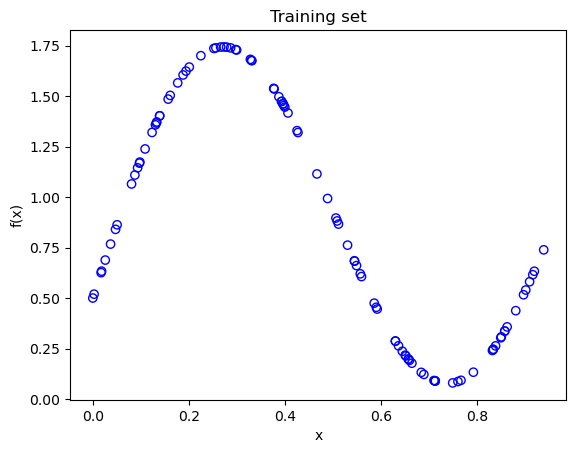

In [6]:
# plot data
plt.scatter(X,Y,facecolors='none', edgecolors='b')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Training set')
plt.savefig('xsinx_target.png')
plt.show()

## Set Device

In [7]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

## Define embedding layer

In [8]:
# define my own embedding layer
def myembedding(x,wires):
    qml.RY(np.arcsin(x), wires=wires[0])
    qml.RY(2*pi*x, wires=wires[1])

## Define the Hamiltonian matrix transformation layer

In [9]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

## Define ansatze

In [10]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubits
    qml.RY(theta[0],wires=0)
    qml.RY(theta[1],wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [11]:
@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))

In [12]:
num_layers=4
theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
print(theta.shape)
print(theta)

(4, 2)
[[2.05237045 3.31160372]
 [5.56653838 2.24479211]
 [5.70849471 3.91668712]
 [0.0994078  5.83982637]]


In [13]:
quantum_net(theta,0)

tensor(0.84707059, requires_grad=True)

In [14]:
print(qml.draw(quantum_net)(theta,0))

0: ──RY(0.00)──H─────────RY(2.05)─╭●──H─────────RY(5.57)─╭●──H─────────RY(5.71)─╭●──H───────
1: ──RY(0.00)──RY(3.31)───────────╰X──RY(2.24)───────────╰X──RY(3.92)───────────╰X──RY(5.84)

───RY(0.10)─╭●──H─┤  <Z>
────────────╰X────┤     


## Add classical layer

In [15]:
# add the classical layer
def classical_quantum_net(theta,w,x):
    r=quantum_net(theta,x)
    return w[0]+w[1]*r+w[2]*r**2

In [16]:
def square_loss(labels,predictions):
    loss=0
    for l,p in zip(labels,predictions):
        loss=loss+(l-p)**2
    loss=loss/len(labels)
    return loss

In [17]:
def cost(theta,w,features,labels):
    preds=[classical_quantum_net(theta,w,x) for x in features]
    return square_loss(labels,preds)

## Model training
Using the Adam optimizer, we update the weights for 200 steps (this takes some time). More steps will lead to a better fit.

In [18]:
w=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [19]:
start=now()
print(start)

2023-08-01 23:45:23.641058


In [20]:
epochs=200
for e in range(1,epochs+1):
    
    (theta,w,_,_),_cost=opt.step_and_cost(cost,theta,w,X,Y)

    if e==1 or e%10==0:
        print(f'Epoch: {e} | Cost: {_cost} | w: {w}')

Epoch: 1 | Cost: 1.1044223649645786 | w: [0.04999999 0.04999995 0.04999994]
Epoch: 10 | Cost: 0.3683800443320283 | w: [0.43668535 0.43170112 0.33883599]
Epoch: 20 | Cost: 0.14698871916473677 | w: [0.55525864 0.43974286 0.29784264]
Epoch: 30 | Cost: 0.03507341146804908 | w: [0.660566   0.7625129  0.54823368]
Epoch: 40 | Cost: 0.01873957028008411 | w: [0.66810872 0.93219993 0.45027423]
Epoch: 50 | Cost: 0.010782872466382985 | w: [0.72735845 0.94458914 0.37759893]
Epoch: 60 | Cost: 0.0060704868225557405 | w: [0.78839749 0.90347374 0.31698741]
Epoch: 70 | Cost: 0.0036153752011841888 | w: [0.82075636 0.93088319 0.23021766]
Epoch: 80 | Cost: 0.0019241171603927324 | w: [0.83824536 0.95936309 0.15845544]
Epoch: 90 | Cost: 0.0009692124779648123 | w: [0.85127608 0.9926449  0.11577963]
Epoch: 100 | Cost: 0.0005569493542117605 | w: [0.85099839 1.02771019 0.08065741]
Epoch: 110 | Cost: 0.00038525698987888974 | w: [0.85210387 1.05116485 0.06269562]
Epoch: 120 | Cost: 0.00032958249350141885 | w: [0.8

KeyboardInterrupt: 

In [21]:
pred_train=np.array([classical_quantum_net(theta,w,x) for x in X])

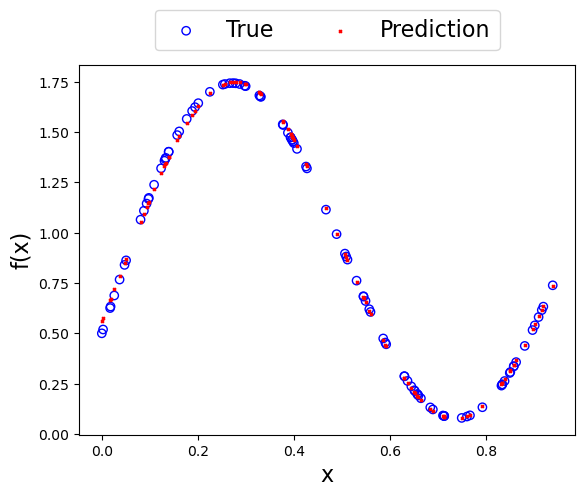

In [22]:
plt.figure()
plt.scatter(X,Y,facecolors='none', edgecolors='b', label='True')
plt.scatter(X,pred_train, color='red',marker="x",s=4,label='Prediction')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
plt.savefig('xsinx_train.png')
plt.show()

In [23]:
train_diff=np.abs(Y-pred_train)

In [24]:
np.max(train_diff)

tensor(0.06150878, requires_grad=True)

In [25]:
np.min(train_diff)

tensor(0.0003781, requires_grad=True)

In [26]:
np.mean(train_diff)

tensor(0.01237536, requires_grad=True)

## Test error

In [27]:
X_test=np.linspace(-0.95,0.95,200)
Y_test=my_objective(X_test)
test_pred=[classical_quantum_net(theta,w,x) for x in X_test]

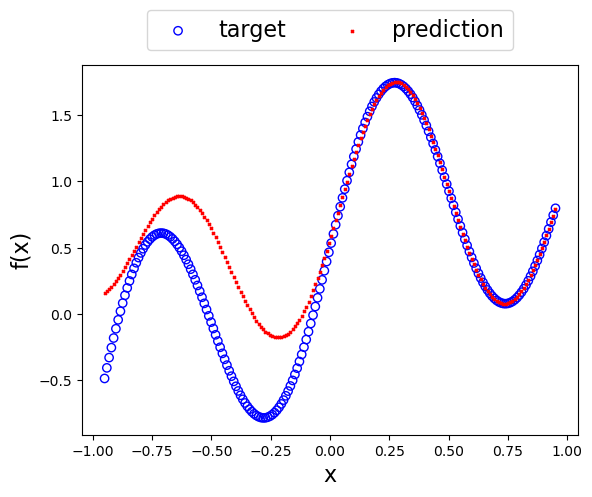

In [28]:
plt.figure()
plt.scatter(X_test,Y_test,facecolors='none', edgecolors='b',label='target')
plt.scatter(X_test,test_pred,color='red',marker="x",s=4,label='prediction')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
plt.savefig('xsinx_test.png')
plt.show()

In [29]:
test_diff=np.abs(Y_test-test_pred)

In [30]:
np.max(test_diff)

tensor(0.78754859, requires_grad=True)

In [31]:
np.min(test_diff)

tensor(3.70906766e-05, requires_grad=True)

In [32]:
np.mean(test_diff)

tensor(0.2254291, requires_grad=True)